In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../../annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

/home/rio/miniconda3/envs/mubind/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:0


In [3]:
import itertools

def _mismatch(word, letters, num_mismatches):
    for locs in itertools.combinations(range(len(word)), num_mismatches):
        this_word = [[char] for char in word]
        for loc in locs:
            orig_char = word[loc]
            this_word[loc] = [l for l in letters if l != orig_char]
        for poss in itertools.product(*this_word):
            yield "".join(poss)



In [4]:
# motif = "ATT"
# x2, y2 = mb.datasets.simulate_xy(motif, n_trials=2100, seqlen=len(motif) + 1, max_mismatches=min(len(motif), 2), counts_size=1)
# x2, y2
# df = pd.DataFrame(data=y2)
# df.columns = [1]
# df.index = x2
# df[0] = 0
# df = df[[0, 1]]

In [5]:
df = mb.bindome.datasets.ProBound.ctcf(flank_length=0)
df = df.sort_values(1, ascending=False).reset_index(drop=True)
# data = df.head(1000)
# data = df.copy()
data = df.sample(1500, random_state=50)
# data = df.copy()
data.index = data['seq']

# remove as many nucleotides as posisble (faster training/convergence)
data.index = data.index.astype(str).str[45:]


# data.index = data.index.astype(str).str[-15:]
del data['seq']

In [6]:
data.shape

(1500, 2)

In [7]:
data = data.sample(data.shape[0], random_state=100)

In [8]:
# # define batches
# batch = np.random.randint(2, size=data.shape[0])

In [9]:
# # data[batch == 0] = data[batch == 0] + 20
# # data[batch == 1] = data[batch == 1] + 10
# data['batch'] = batch
#
# data = data[data['batch'] == 1]

In [10]:


from matplotlib import rcParams
rcParams['figure.figsize'] = 5, 1

In [11]:
# TODO: skipped for now
n_rounds = 1

print('loading object (# entries)', data.shape[0])
dataset = mb.datasets.SelexDataset(data, n_rounds=n_rounds, labels=[0, 1])
train = tdata.DataLoader(dataset=dataset,
                         # batch_size=256,
                         batch_size=512,
                         shuffle=False)

loading object (# entries) 1500
(1500, 2)


In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
import numpy as np

In [14]:
%load_ext line_profiler


In [15]:
# %lprun -f mb.tl.train_network mb.tl.train_network(model, train, device, next_optimiser, criterion, num_epochs=20, early_stopping=100, log_each=2, dirichlet_regularization=0, exp_max=40, verbose=0)

In [16]:
# %lprun -f mb.tl.train_iterative mb.tl.train_iterative(train, device, w=18, show_logo=False, opt_kernel_shift=0, opt_kernel_length=0, dirichlet_regularization=dirichlet_regularization, lr=[0.01, 0.01], weight_decay=[0.01, 0.001], ignore_kernel=ignore_kernel, num_epochs=2, early_stopping=100, use_dinuc=False, n_kernels=n_kernels, log_each=log_each, stop_at_kernel=None)

In [17]:
y_pred = torch.tensor(data.copy().to_numpy() - 100)
y_true = torch.tensor(data.copy().to_numpy() - 100)
torch.mean(y_pred - y_true * torch.log(y_pred))
torch.log(y_pred)
criterion = mb.tl.PoissonLoss()
criterion(y_pred, y_true)

tensor(nan)

In [18]:
# assign batch and data type

# data['batch'] = 0
# data['is_count_data'] = 1
# n_batches=3

dirichlet_regularization = 0
# for dirichlet_regularization_log in range(-5, 3):

n_epochs = 100
log_each = 2
n_kernels = 2
w = 15 # min(len(motif), 6)
opt_kernel_shift=1
opt_kernel_length=1

from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 1

import time
t0 = time.time()

criterion = mb.tl.PoissonLoss()

for ignore_kernel in [1]: # [0, 1]:
    print('\n\n##NEW JOB')
    print('ignore kernel', ignore_kernel)
    model_by_k, res_next = mb.tl.train_iterative(train, device, w=w, show_logo=0, criterion=criterion,
                                                 opt_kernel_shift=0, opt_kernel_length=0,
                                                 dirichlet_regularization=dirichlet_regularization, # 10 ** dirichlet_regularization_log,
                                                 lr=[0.01, 0.01], weight_decay=[0.01, 0.001], ignore_kernel=ignore_kernel,
                                                 num_epochs=n_epochs, early_stopping=[10, 100], use_dinuc=False, # optimiser=torch.optim.LBFGS,
                                                 n_kernels=n_kernels, log_each=log_each, stop_at_kernel=None) #  seed=seed) # seeds.index[0]) #
    print('##DONE....\n\n')


print('total time: %.3f s' % ((time.time() - t0)))
# res = []
# model_by_k = {}

model = model_by_k





##NEW JOB
ignore kernel 1
next w 15 <class 'int'>
# rounds 1
# batches 1
# enr_series True

Kernel to optimize 0

FREEZING KERNELS
setting grad status of kernel at 0 to 1
setting grad status of kernel at 1 to 0


kernels mask [0 1]
optimizing using <class 'torch.optim.adam.Adam'> and <class 'mubind.tl.loss.PoissonLoss'> n_epochs 100 early_stopping 10
lr= 0.01, weight_decay= 0.01, dir weight= 0
Epoch:  3, Loss: 0.845864 , best epoch: 1 secs per epoch: 0.930 s
Epoch:  5, Loss: 0.844696 , best epoch: 3 secs per epoch: 0.616 s
Epoch:  7, Loss: 0.844808 , best epoch: 4 secs per epoch: 0.510 s
Epoch:  9, Loss: 0.844735 , best epoch: 4 secs per epoch: 0.463 s
Epoch: 11, Loss: 0.844534 , best epoch: 9 secs per epoch: 0.432 s
Epoch: 13, Loss: 0.844523 , best epoch: 11 secs per epoch: 0.413 s
Epoch: 15, Loss: 0.844600 , best epoch: 11 secs per epoch: 0.403 s
Epoch: 17, Loss: 0.844612 , best epoch: 11 secs per epoch: 0.404 s
Epoch: 19, Loss: 0.844583 , best epoch: 11 secs per epoch: 0.417 s
Epo

### We can visualize the overall results obtained by the network, once the training is finished

In [19]:
import mubind as mb

In [20]:
model = model_by_k
mb.tl.scores(model, train)


{'r2_counts': 0.3013869884129764,
 'r2_foldchange': 0.01345691582487718,
 'r2_enr': -0.06106758185115435,
 'pearson_foldchange': 0.12573660304373807}

In [21]:
counts = mb.tl.predict(model, train)
counts

,t0,t1,p0,p1,enr_pred,enr_obs,f_pred,f_obs
ACTTCCAT,0.0,1.0,0.560630,0.439370,0.922301,2.0,-0.035128,0.301030
CTTCCATC,0.0,1.0,0.560630,0.439370,0.922301,2.0,-0.035128,0.301030
TGATGGAA,0.0,1.0,0.560630,0.439370,0.922301,2.0,-0.035128,0.301030
GTGATGGA,0.0,3.0,1.697752,1.302248,0.853395,4.0,-0.068850,0.602060
CCATCACG,1.0,2.0,1.546589,1.453411,0.963410,1.5,-0.016189,0.176091
...,...,...,...,...,...,...,...,...
CCTATCTA,1.0,0.0,0.554490,0.445510,0.929894,0.5,-0.031567,-0.301030
AGATAGGA,1.0,0.0,0.554490,0.445510,0.929894,0.5,-0.031567,-0.301030
GATAGGAC,1.0,0.0,0.554490,0.445510,0.929894,0.5,-0.031567,-0.301030
AGTCCTAT,1.0,0.0,0.554490,0.445510,0.929894,0.5,-0.031567,-0.301030


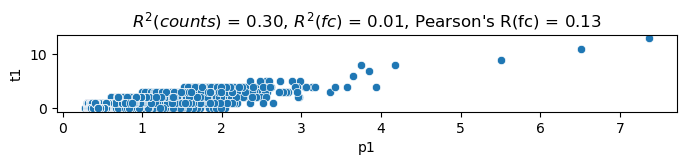

{'r2_counts': 0.3013869884129764,
 'r2_foldchange': 0.01345691582487718,
 'r2_enr': -0.06106758185115435,
 'pearson_foldchange': 0.12573660304373807}

In [22]:
mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1')



#activities
[[[1.0000745  0.90032023]
  [0.99999857 0.619087  ]]]

#log_etas
Parameter containing:
tensor([[ 0.7396, -0.7396]], device='cuda:0', requires_grad=True)


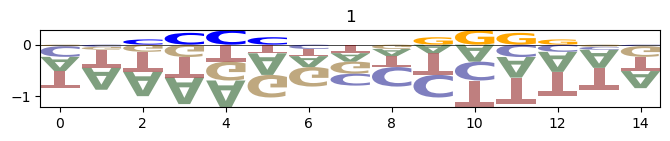

In [23]:
mb.pl.conv_mono(model)
